11.5 - 4.5 = 7.0
[22.1]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


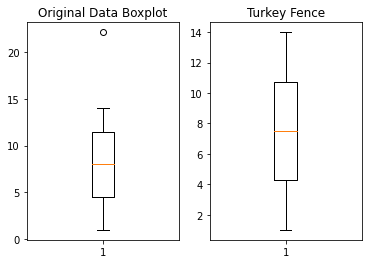

In [18]:
# 이상치(Outlier)를 판단하는 Turkey Fence

import numpy as np
import matplotlib.pyplot as plt

data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22.1])

figure = plt.figure()

ax1 = figure.add_subplot(1,2,1) # 1행 2열의 첫번째
ax2 = figure.add_subplot(1,2,2) # 1행 2열의 두번째

ax1.set_title('Original Data Boxplot')
ax1.boxplot(data)

# 사분위 값을 구하는 Numpy의 함수. 사분위 범위(IQR)
first = np.percentile(data, 25) # 1사분위(Q1, 25%)
third = np.percentile(data, 75) # 3사분위(Q3, 75%)

IQR_value = third - first
print(third, '-', first, '=', IQR_value)

upper_fence = third + (IQR_value * 1.5)
lower_fence = first - (IQR_value * 1.5)

# boolean indexing을 이용해서 이상치를 추출하자
print(data[(data > upper_fence) | (data < lower_fence)]) # [22.1]. |은 or 연산

# boolean indexing을 이용해서 이상치를 제거하고 나머지 데이터를 추출하자
result = data[(data <= upper_fence) & (data >= lower_fence)]
print(result) # [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]

ax2.boxplot(result)
ax2.set_title('Turkey Fence')
plt.show()

In [24]:
# 이상치(Outlier)를 판단하는 표준화 방법(Z-Score)

data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22.1])

mean = data.mean() # 8.473333333333333
std = data.std() # 5.331974826980671

zscore_data = (data - mean) / std

print(zscore_data)

[-1.40160702 -1.21405925 -1.02651147 -0.8389637  -0.65141593 -0.46386816
 -0.27632038 -0.08877261  0.09877516  0.28632293  0.4738707   0.66141848
  0.84896625  1.03651402  2.55565098]


In [39]:
# scipy는 sklearn과 유사한 통계전용 모듈

from scipy import stats

data = np.array([-10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22.1])

zscore_threshold = 2.0 # 일반적인 기준

# print(np.abs(stats.zscore(data))) # np.abs로 z-score의 절대값을 구해서 -2 ~ 2 범위 내의 것들을 구함

outlier = data[np.abs(stats.zscore(data)) > zscore_threshold]
# print(outlier) # [-10.   22.1]

data[np.isin(data, outlier, invert=True)] # invert=True 옵션을 주면 True False를 역으로 바꿀 수 있음
# array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
#        14.])

[-10.   22.1]


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

In [54]:
# 온도에 따른 Ozone량 예측 -> Python 구현 + 결측치와 이상치 처리도 같이 진행
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 다변수 함수의 수치미분 코드
def numerical_derivative(f,x):

    delta_x = 1e-4
    derivative_x = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'])

    while not it.finished:
        
        idx = it.multi_index
        tmp = x[idx]

        x[idx] = tmp + delta_x
        fx_plus_delta = f(x)

        x[idx] = tmp - delta_x
        fx_minus_delta = f(x)

        derivative_x[idx] = (fx_plus_delta - fx_minus_delta) / (2 * delta_x)

        x[idx] = tmp
        it.iternext()
        
    return derivative_x

# Raw Data Set Loading
df = pd.read_csv('./data/ozone.csv')
training_data = df[['Ozone', 'Temp']]

training_data.dropna(how='any', inplace=True) # 결치가 존재하는 행을 삭제

# 데이터에 이상치가 있는지 확인하고 제거
zscore_threshold = 2.0
outlier = training_data['Ozone'][(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)]
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]

# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

# Weight, bias
W = np.random.rand(1,1)
b = np.random.rand(1)

# loss function
def loss_func(input_data):
    W = input_data[0].reshape(1,1)
    b = input_data[1]
    
    y = np.dot(x_data, W) + b
    return np.mean(np.power(t_data-y,2))

# predict
def predict(x):
    y = np.dot(x, W) + b
    return y

# learning_rate
learning_rate = 1e-4

# 반복 학습
for step in range(300000):
    
    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    W = W - derivative_result[0].reshape(1,1)
    b = b - derivative_result[1]
    
    if step % 30000 == 0:
        input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
        print('W : {}, b : {}, loss : {}'.format(W, b, loss_func(input_param)))

W : [[0.49575807]], b : [0.37397524], loss : 493.2677739116658
W : [[0.63002676]], b : [-10.24092639], loss : 455.6734091331335
W : [[0.7538855]], b : [-19.96351262], loss : 424.1385353365726
W : [[0.86733249]], b : [-28.86880395], loss : 397.6825613992969
W : [[0.97124295]], b : [-37.02550341], loss : 375.48749693135693
W : [[1.06641856]], b : [-44.49653871], loss : 356.86709429802477
W : [[1.15359356]], b : [-51.3395478], loss : 341.2456305836442
W : [[1.2334405]], b : [-57.60732349], loss : 328.1401068532783
W : [[1.30657539]], b : [-63.34822073], loss : 317.1453143429463
W : [[1.37356245]], b : [-68.60652972], loss : 307.9213058384321


In [55]:
# 학습종료 후 예측 (Temp : 62)
predict_data = predict(np.array([[62]]))
print('온도가 62일 때 오존량 : {}'.format(predict_data)) # [[15.5421609]]

온도가 62일 때 오존량 : [[15.5421609]]


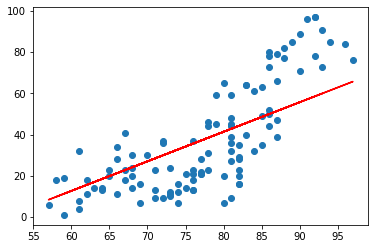

In [56]:
# 그래프로 표현해보자
import matplotlib.pyplot as plt

plt.scatter(x_data.ravel(), t_data.ravel())
plt.plot(x_data.ravel(), x_data.ravel()*W.ravel() + b, color='r')
plt.show()

sklearn으로 구한 온도가 62도 일 때의 오존량 : [[4.51299041]]


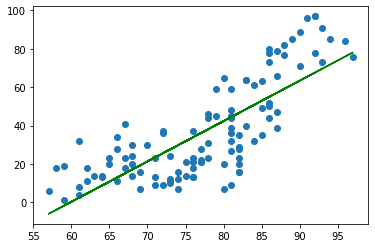

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

# Raw Data Set Loading
df = pd.read_csv('./data/ozone.csv')

# Linear Regression으로 하나의 독립변수만 사용함
training_data = df[['Ozone', 'Temp']]

# 결치가 존재하는 행을 삭제
training_data.dropna(how='any', inplace=True)

# 데이터에 이상치가 있는지 확인하고 제거
zscore_threshold = 2.0
outlier = training_data['Ozone'][(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)]
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]

# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

# model 생성
model = linear_model.LinearRegression()

# model 학습
model.fit(x_data, t_data)

# 예측
result = model.predict(np.array([[62]]))
print('sklearn으로 구한 온도가 62도 일 때의 오존량 : {}'.format(result)) # [[4.51299041]]

# 그래프 표현
plt.scatter(x_data.ravel(), t_data.ravel())
plt.plot(x_data.ravel(), 
         x_data.ravel()*model.coef_.ravel() + model.intercept_, color='g')
plt.show()

In [66]:
# 정규화 작업을 포함해서 모델 학습 진행(Min-Max Scaling) - Python

import pandas as pd
import seaborn as sns

titanic = sns.load_dataset('titanic')
df = titanic[['age', 'fare']]

display(df.head())

def min_max(s):
    return (s - s.min()) / (s.max() - s.min())

result = df.apply(min_max, axis=0)

display(result.head())

,age,fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


,age,fare
0,0.271174,0.014151
1,0.472229,0.139136
2,0.321438,0.015469
3,0.434531,0.103644
4,0.434531,0.015713


In [182]:
# 정규화 작업을 포함해서 모델 학습 진행(Min-Max Scaling) - Sklearn의 기능(MinMaxScaler)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model # LinearRegression 모델
from scipy import stats # 이상치 처리
from sklearn.preprocessing import MinMaxScaler # 정규화 처리
import warnings
warnings.filterwarnings('ignore')

# figure - plt.figure() # python과 sklearn으로 구현한 그래프를 한번에 비교하자
# python_ax = figure.add_subplot(1,2,1)
# sklearn_ax = figure.add_subplot(1,2,2)

# Raw Data Set Loading
df = pd.read_csv('./data/ozone.csv')

# Linear Regression으로 하나의 독립변수만 사용함
training_data = df[['Ozone', 'Temp']]

# 결치가 존재하는 행을 삭제
training_data.dropna(how='any', inplace=True)

# 데이터에 이상치가 있는지 확인하고 제거
zscore_threshold = 2.0
outlier = training_data['Ozone'][(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)]
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]

# 정규화 처리
scaler_x = MinMaxScaler() # 온도 처리를 위한 scaler(독립변수들을 위한)
scaler_t = MinMaxScaler() # 오존량 처리를 위한 scaler(종속변수를 위한)

scaler_x.fit(training_data['Temp'].values.reshape(-1,1)) # 2차원으로
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))

scaled_Temp = scaler_x.transform(training_data['Temp'].values.reshape(-1,1))
scaled_Ozone = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

training_data['Temp'] = scaled_Temp
training_data['Ozone'] = scaled_Ozone

display(training_data.head())

# Training Data Set
p_x_data = training_data['Temp'].values.reshape(-1,1)
p_t_data = training_data['Ozone'].values.reshape(-1,1)

# Weight, bias
W = np.random.rand(1,1)
b = np.random.rand(1)

# loss function
def loss_func(input_data):
    W = input_data[0].reshape(1,1)
    b = input_data[1]
    
    y = np.dot(p_x_data, W) + b
    return np.mean(np.power(p_t_data-y,2))

# predict
def predict(x):
    y = np.dot(x, W) + b
    return y

# learning_rate
learning_rate = 1e-4

# 반복 학습
for step in range(300000):
    
    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    W = W - derivative_result[0].reshape(1,1)
    b = b - derivative_result[1]
    
    if step % 30000 == 0:
        input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
        print('W : {}, b : {}, loss : {}'.format(W, b, loss_func(input_param)))

,Ozone,Temp
0,0.416667,0.250
1,0.364583,0.375
2,0.114583,0.425
3,0.177083,0.125
5,0.281250,0.225


W : [[0.4387315]], b : [0.14768411], loss : 0.03884366987227514
W : [[0.54360343]], b : [0.10409193], loss : 0.034411007368615965
W : [[0.62039286]], b : [0.06324822], loss : 0.03187497087615693
W : [[0.67946461]], b : [0.03182384], loss : 0.030374111076493345
W : [[0.72490815]], b : [0.00764925], loss : 0.02948588246615274
W : [[0.75986759]], b : [-0.01094812], loss : 0.028960217067956005
W : [[0.78676167]], b : [-0.02525496], loss : 0.02864912135718473
W : [[0.80745113]], b : [-0.03626113], loss : 0.028465010815398466
W : [[0.8233674]], b : [-0.04472811], loss : 0.02835605177024542
W : [[0.8356117]], b : [-0.0512417], loss : 0.02829156837127503


In [186]:
# 학습종료 후 예측 (Temp : 62) -> [[53.03797526]]?!?! 독립변수도 정규화 해줘야 한다!
predict_data = np.array([[62]])
scaled_predict_data = scaler_x.transform(predict_data) # 입력값 또한 정규화
python_result = predict(scaled_predict_data)

python_result = scaler_t.inverse_transform(python_result) # 정규화 이전의 값으로 복원해야 함

print(python_result) # [[5.74013754]]

[[5.74013754]]


In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

# Raw Data Set Loading
df = pd.read_csv('./data/ozone.csv')

# Linear Regression으로 하나의 독립변수만 사용함
training_data = df[['Ozone', 'Temp']]

# 결치가 존재하는 행을 삭제
training_data.dropna(how='any', inplace=True)

# 데이터에 이상치가 있는지 확인하고 제거
zscore_threshold = 2.0
outlier = training_data['Ozone'][(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)]
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]

# 정규화 처리는 sklearn이 알아서 진행

# Training Data Set
s_x_data = training_data['Temp'].values.reshape(-1,1)
s_t_data = training_data['Ozone'].values.reshape(-1,1)

# model 생성
model = linear_model.LinearRegression()

# model 학습
model.fit(s_x_data, s_t_data)

# 예측
result = model.predict(np.array([[62]]))
print('sklearn으로 구한 온도가 62도 일 때의 오존량 : {}'.format(result)) # [[4.51299041]]

sklearn으로 구한 온도가 62도 일 때의 오존량 : [[4.51299041]]


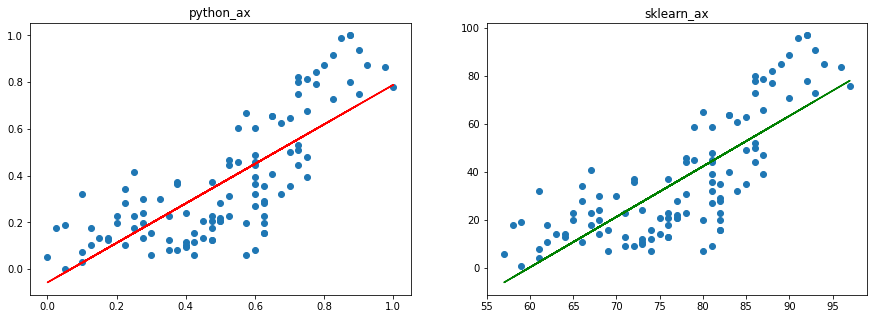

In [193]:
# python과 sklearn으로 구현한 그래프를 한번에 비교하자
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(15,5))
python_ax = figure.add_subplot(1,2,1)
sklearn_ax = figure.add_subplot(1,2,2)

python_ax.set_title('python_ax')
python_ax.scatter(p_x_data.ravel(), p_t_data.ravel())
python_ax.plot(p_x_data.ravel(), p_x_data.ravel()*W.ravel() + b, color='r')

sklearn_ax.set_title('sklearn_ax')
sklearn_ax.scatter(s_x_data.ravel(), s_t_data.ravel())
sklearn_ax.plot(s_x_data.ravel(), s_x_data.ravel()*model.coef_.ravel() + model.intercept_, color='g')

plt.show()

In [195]:
# 메모리 초기화 (이전의 함수와 변수들을 메모리에서 지우는 매직 펑션)
%reset 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model # LinearRegression 모델
from scipy import stats # 이상치 처리
from sklearn.preprocessing import MinMaxScaler # 정규화 처리
import warnings
warnings.filterwarnings('ignore')

# 다변수 함수의 수치미분 코드
def numerical_derivative(f,x):

    delta_x = 1e-4
    derivative_x = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'])

    while not it.finished:
        
        idx = it.multi_index
        tmp = x[idx]

        x[idx] = tmp + delta_x
        fx_plus_delta = f(x)

        x[idx] = tmp - delta_x
        fx_minus_delta = f(x)

        derivative_x[idx] = (fx_plus_delta - fx_minus_delta) / (2 * delta_x)

        x[idx] = tmp
        it.iternext()
        
    return derivative_x

# Raw Data Loading. NaN, Outlier 존재하지 않음. 각 변수의 scale이 비슷하기 때문에 정규화가 굳이 필요 없음
df = pd.read_csv('./data/student_exam_score.csv')
# display(df)

# Training Data Set
x_data = df.drop('exam', axis=1, inplace=False)
t_data = df.iloc[:,-1].values.reshape(-1,1)

# Weight, bias
W = np.random.rand(3,1) # 행렬곱연산(데이터의 열 × W의 행)이 일어날 수 있도록 shape을 맞춰주기
b = np.random.rand(1)

# loss function
def loss_func(input_data): # [w1 w2 w3 b]
    
    input_w = input_data[:-1].reshape(-1,1) # 행은 알아서, 열은 1로 만들어줘! (3,1)
    input_b = input_data[-1:]
    
    y = np.dot(x_data, input_w) + input_b
    return np.mean(np.power(t_data-y,2)) # MSE(평균제곱오차)

# predict
def predict(x):
    y = np.dot(x, W) + b
    return y

# learning_rate
learning_rate = 1e-5

# 반복 학습
for step in range(300000):
    
    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0) # [w1 w2 w3 b]
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    W = W - derivative_result[:-1].reshape(-1,1) # (3,1)
    b = b - derivative_result[-1]
    
    if step % 30000 == 0:
        input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
        print('W : {}, b : {}, loss : {}'.format(W, b, loss_func(input_param)))

W : [[0.75704147]
 [0.87293951]
 [0.08290194]], b : [0.11776917], loss : 716.9251288061897
W : [[0.35624398]
 [0.53000139]
 [1.12626181]], b : [0.07518911], loss : 6.113046624939858
W : [[0.35598491]
 [0.53027968]
 [1.12685259]], b : [0.02445161], loss : 6.104462995534996
W : [[0.35598423]
 [0.53042053]
 [1.12731954]], b : [-0.02570377], loss : 6.096076903392734
W : [[0.3559837 ]
 [0.53055968]
 [1.12778106]], b : [-0.07528226], loss : 6.087882616566788
W : [[0.35598318]
 [0.53069724]
 [1.12823726]], b : [-0.1242905], loss : 6.07987574811723
W : [[0.35598266]
 [0.53083321]
 [1.12868823]], b : [-0.17273504], loss : 6.072052011441858
W : [[0.35598215]
 [0.53096762]
 [1.129134  ]], b : [-0.22062236], loss : 6.064407217980948
W : [[0.35598165]
 [0.53110048]
 [1.12957465]], b : [-0.26795889], loss : 6.056937274974839
W : [[0.35598115]
 [0.53123181]
 [1.13001022]], b : [-0.31475094], loss : 6.049638183272781


In [203]:
# 학습종료 후 예측
result = predict(np.array([[89, 100, 95]]))
print(result) # [[191.84931203]]

[[191.84931203]]


In [204]:
from sklearn import linear_model

model = linear_model.LinearRegression() # model 생성

model.fit(x_data, t_data) # model 학습

result_sklearn = model.predict(np.array([[89, 100, 95]])) # 예측
print(result_sklearn) # [[192.50147537]]

[[192.50147537]]
